In [1]:
from tensorflow.python.keras.layers import Input, Dense, Dropout, LSTM, Activation
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

## PREPROCESSING

In [2]:
SPX = pd.read_fwf('data/SPX.txt' ,names=['Date', 'Close'], parse_dates=True)

In [3]:
SPX.head()

,Date,Close
0,06/01/1995,"460,68"
1,13/01/1995,"465,97"
2,20/01/1995,"464,78"
3,27/01/1995,"470,39"
4,03/02/1995,"478,64"


In [6]:
volatilite = pd.read_fwf('data/VIX.txt' ,names=['Date', 'Close'], parse_dates=True)

In [7]:
volatilite.head()

,Date,Close
0,06/01/1995,"13,13"
1,13/01/1995,"11,1"
2,20/01/1995,"12,15"
3,27/01/1995,"11,25"
4,03/02/1995,"10,98"


In [8]:
SPX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292 entries, 0 to 1291
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1292 non-null   object
 1   Close   1292 non-null   object
dtypes: object(2)
memory usage: 20.3+ KB


In [9]:
SPX['Close'] = SPX['Close'].apply(lambda x: float(x.split()[0].replace(',', '.')))

In [10]:
print(SPX.index)

RangeIndex(start=0, stop=1292, step=1)


## **EVOLUTION DES NOS DONNEES**

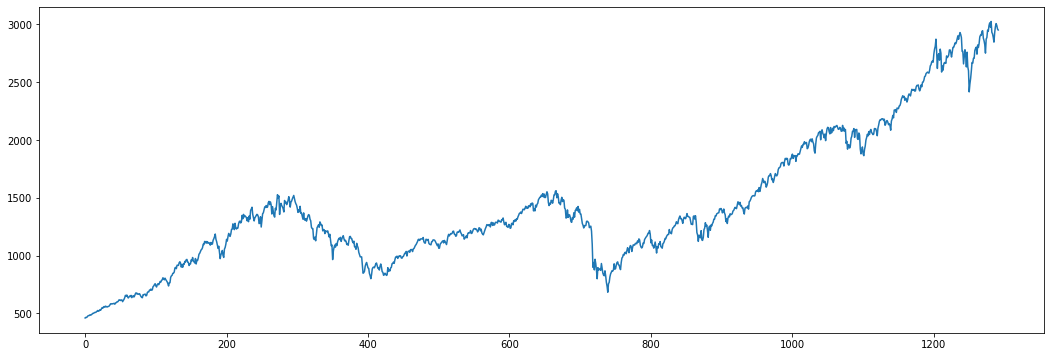

In [12]:
SPX['Close'].plot(figsize=(18, 6))
plt.show()

In [14]:
SPX_ = SPX.set_index('Date')

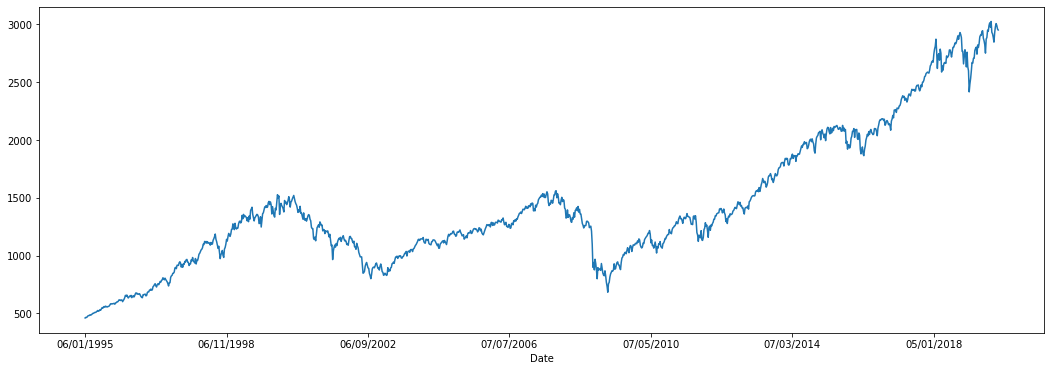

In [15]:
SPX_['Close'].plot(figsize=(18, 6))
plt.show()

## SPLIT DONNEE DE TRAIN ET TEST

In [18]:
train_SPX = SPX.loc[0:1000,'Close']
test_SPX = SPX.loc[1000:,'Close']

Text(0, 0.5, 'SPX/USDT')

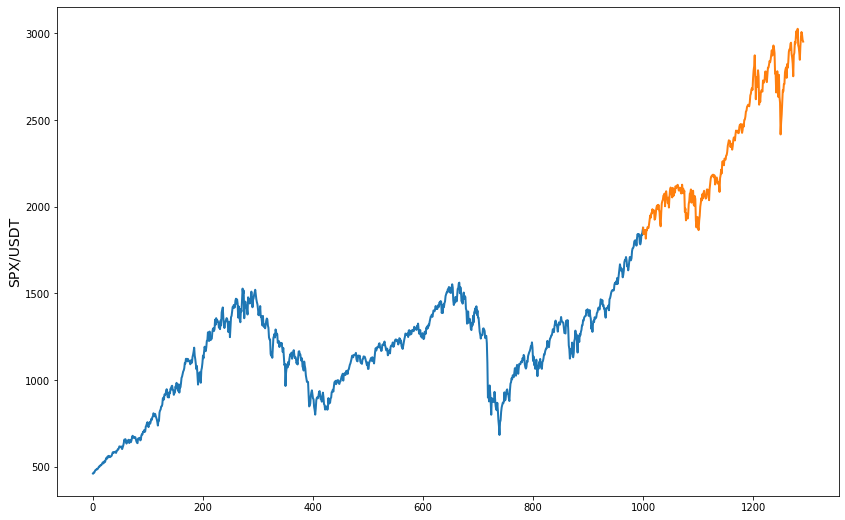

In [19]:
fig, ax = plt.subplots(1, figsize=(14, 9))
ax.plot(train_SPX, label='training data', linewidth=2)
ax.plot(test_SPX, label='test data', linewidth=2)
ax.set_ylabel('SPX/USDT', fontsize=14)

---

## DONNEE D'ENTRAINEMENT

<AxesSubplot:>

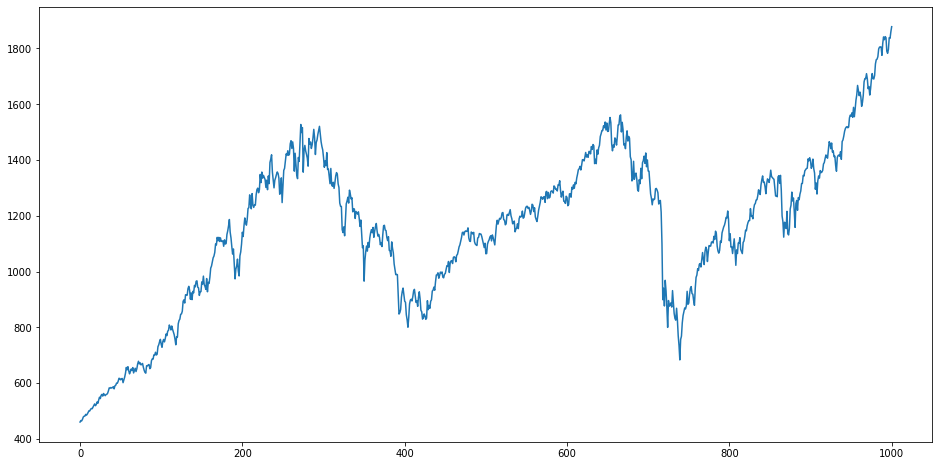

In [20]:
train_SPX.plot(figsize=(16,8))

### DONNEE DE TEST

<AxesSubplot:>

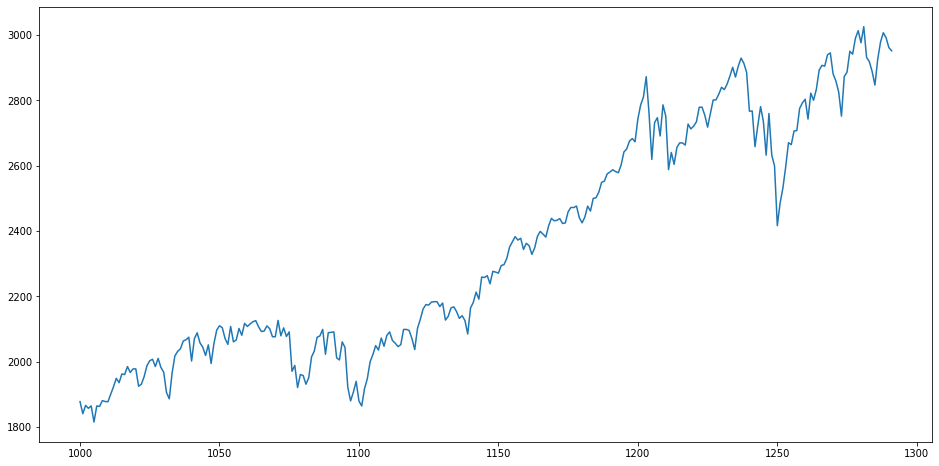

In [21]:
test_SPX.plot(figsize=(16,8))

# NORMALISATION DE DONNEES


In [22]:
def normalise_zero_base(data):
    return data / data.iloc[0] - 1

In [26]:
def prepare_data(train_SPX, test_SPX,window_len=10, zero_base=True, test_size=0.2):
    def extract_window_data(data, window_len=5, zero_base=True):
        window_data = []
        for idx in range(len(data) - window_len):
            tmp = data[idx: (idx + window_len)].copy()
            if zero_base:
                tmp = normalise_zero_base(tmp)
            window_data.append(tmp.values)
        return np.array(window_data)

    X_train = extract_window_data(train_SPX, window_len, zero_base)
    X_test = extract_window_data(test_SPX, window_len, zero_base)
    y_train = train_SPX[window_len:].values
    y_test = test_SPX[window_len:].values
    if zero_base:
        y_train = y_train / train_SPX[:-window_len].values - 1
        y_test = y_test / test_SPX[:-window_len].values - 1
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return train_SPX, test_SPX, X_train, X_test, y_train, y_test

# MODELISATION 1 LSTM

- Creation de modele lstm

In [27]:
def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

- Les paramettres pour l'entrainement du model

## SPLIT DATA

In [28]:
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
train_SPX, test_SPX, window_len=5, zero_base=True, test_size=0.2)

In [31]:
print('longeur de X training data', X_train.shape)
print('longeur de Y training data',y_train.shape)

longeur de X training data (996, 5, 1)
longeur de Y training data (996,)


In [32]:
print('longeur de X test data',X_test.shape)
print('longeur de y test data',y_test.shape)

longeur de X test data (287, 5, 1)
longeur de y test data (287,)


## TRAINING MODELE 1 LSTM

In [33]:
model = build_lstm_model(
    X_train, output_size=1, neurons=50, dropout=0.24, loss='mse',
    optimizer='adam')
modelfit = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32, verbose=1, shuffle=True)
     

Epoch 1/30
32/32 [==============================] - 61s 272ms/step - loss: 0.0025 - val_loss: 9.1391e-04
Epoch 2/30
32/32 [==============================] - 1s 21ms/step - loss: 0.0017 - val_loss: 7.0408e-04
Epoch 3/30
32/32 [==============================] - 1s 24ms/step - loss: 0.0013 - val_loss: 5.4576e-04
Epoch 4/30
32/32 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 5.3239e-04
Epoch 5/30
32/32 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 4.6761e-04
Epoch 6/30
32/32 [==============================] - 1s 21ms/step - loss: 9.7354e-04 - val_loss: 4.4436e-04
Epoch 7/30
32/32 [==============================] - 1s 18ms/step - loss: 8.9623e-04 - val_loss: 4.7497e-04
Epoch 8/30
32/32 [==============================] - 1s 17ms/step - loss: 8.6021e-04 - val_loss: 4.5202e-04
Epoch 9/30
32/32 [==============================] - 1s 21ms/step - loss: 8.3486e-04 - val_loss: 3.8508e-04
Epoch 10/30
32/32 [==============================] - 1s

## COURBE D'ENTRAINEMENT ET DE TEST

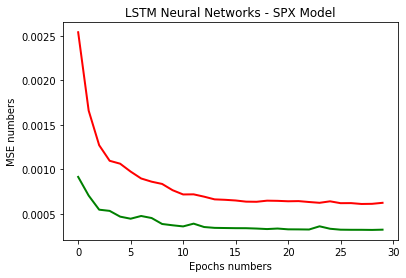

In [34]:
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Networks - SPX Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [36]:
targets = test_SPX[5:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.013042080480698754

In [37]:
from sklearn.metrics import mean_squared_error
SCORE_MSE=mean_squared_error(preds, y_test)
SCORE_MSE

0.00032122328062203693

In [38]:
from sklearn.metrics import r2_score
r2_score1=r2_score(y_test, preds)
r2_score1*100

73.77215744032684

In [41]:
preds = pd.Series(index=targets.index, data=preds)

# PREDICTION DU MODEL 1

<AxesSubplot:>

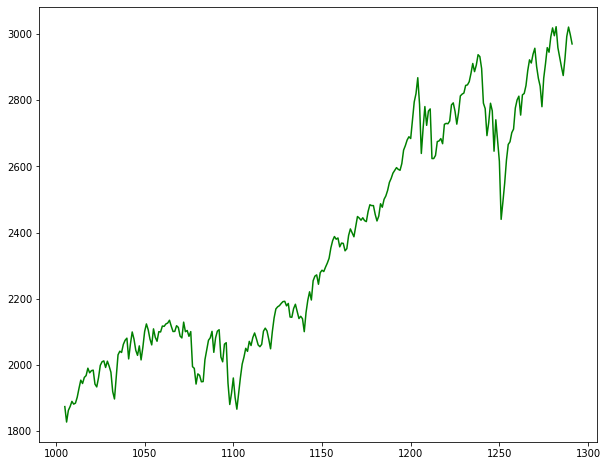

In [42]:
preds = pd.Series(index=targets.index, data=preds)
preds.plot(figsize=(10,8) , c='g')

## VRAIE DONNE DU TEST

In [ ]:
test_SPX.plot(figsize=(10,8), c='r')

## COMPARAISON DES VRAIE DONNEE AVEC LES PREDICTIONS

## PREDICTION DU MODEL SUR LES DONNEES DE TEST

In [49]:

def line_plot(line1, line2,label1=None, label2=None,title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(14, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw, c='r')
    ax.set_ylabel('SPX/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

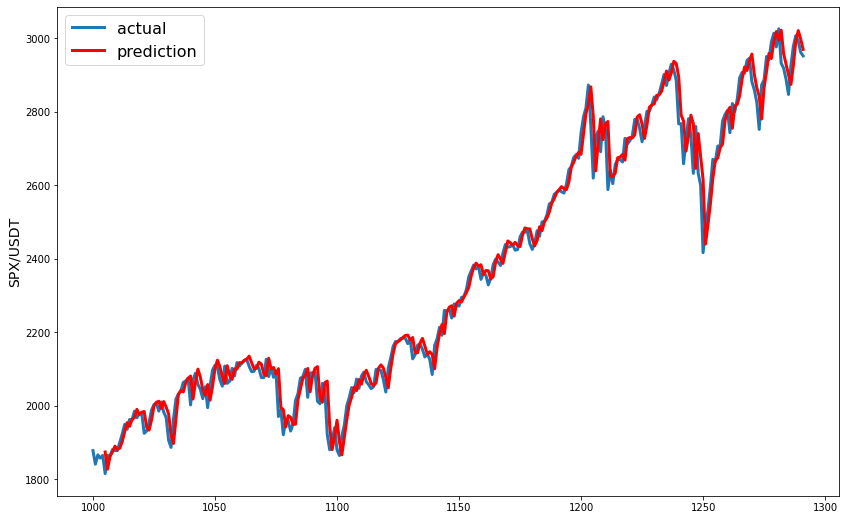

In [53]:
line_plot(test_SPX, preds, 'actual', 'prediction', lw=3)

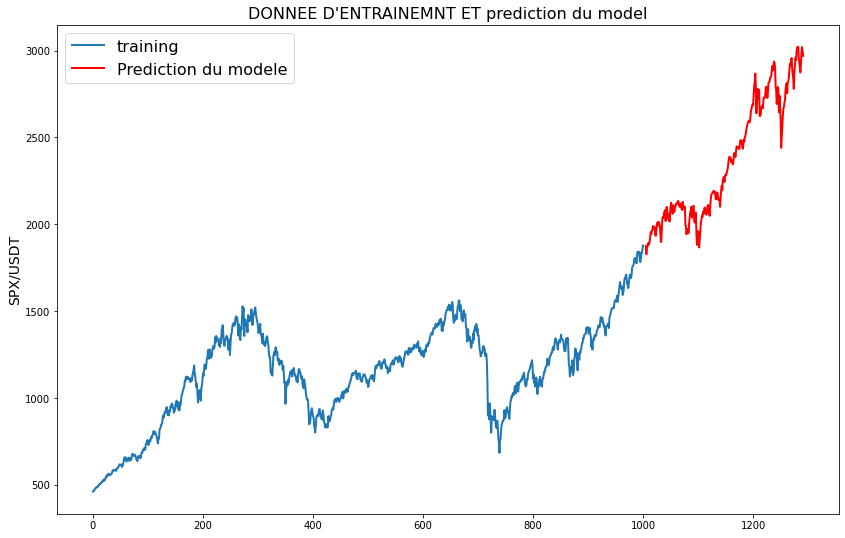

In [50]:
line_plot(train_SPX,preds, 'training', 'Prediction du modele', title="DONNEE D'ENTRAINEMNT ET prediction du model")

---

## MODEL 2 GRU

In [54]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,GRU
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from pandas import Series
import keras
from keras import optimizers
from keras.layers import Activation, Dense,Dropout

In [70]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, LSTM, Activation, GRU
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from pandas import Series
from tensorflow.python.keras import optimizers

In [55]:
df = SPX.set_index('Date')
data=df.copy()

In [56]:
data.head()

,Close
Date,
06/01/1995,460.68
13/01/1995,465.97
20/01/1995,464.78
27/01/1995,470.39
03/02/1995,478.64


In [62]:
X = np.array(SPX['Close'])
X = X.reshape((1292, 1))

training_data_len = math.ceil(len(X)* 0.75)

sc = MinMaxScaler(feature_range=(0,1))
training_data = sc.fit_transform(X)
training_data

array([[0.        ],
       [0.00206228],
       [0.00159837],
       ...,
       [0.98682323],
       [0.97501092],
       [0.97122942]])

In [71]:
split_val = 887
train_data = training_data[0:split_val  , : ]

X_train = []
y_train = []
for i in range(180, len(train_data)):
    X_train.append(train_data[i-180:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print('Nombre des lignes et colonnes: ', X_train.shape)

test_data = training_data[split_val - 180: , : ]
X_test = []
y_test =  X[split_val : , : ]
for i in range(180,len(test_data)):
    X_test.append(test_data[i-180:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print('Nombre des lignes et colonnes : ', X_test.shape)


Nombre des lignes et colonnes:  (707, 180, 1)
Nombre des lignes et colonnes :  (405, 180, 1)


In [72]:
model_GRU = Sequential()
model_GRU.add(LSTM(units = 200, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units = 50, return_sequences = True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units = 50, return_sequences = True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units = 50, return_sequences=True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units = 50, return_sequences=True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units = 50, return_sequences=True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units = 50))
model_GRU.add(Dropout(0.2))
model_GRU.add(Dense(units = 1))

In [73]:
model_GRU.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error')


In [ ]:
model_GRU.fit(X_train, y_train, epochs = 20, batch_size = 32)

In [77]:
pred = model_GRU.predict(X_test)
pred = sc.inverse_transform(pred)


In [78]:
pred

array([[1156.5093],
       [1156.3217],
       [1158.6057],
       [1163.7921],
       [1171.7893],
       [1182.2513],
       [1194.4985],
       [1207.7227],
       [1221.0956],
       [1233.8248],
       [1245.2026],
       [1255.113 ],
       [1263.7661],
       [1271.4695],
       [1278.2683],
       [1283.5641],
       [1286.6415],
       [1287.5376],
       [1286.5535],
       [1283.7845],
       [1278.5105],
       [1270.217 ],
       [1258.7942],
       [1245.3848],
       [1232.3007],
       [1221.8478],
       [1215.7534],
       [1214.6217],
       [1217.8964],
       [1224.3052],
       [1232.6367],
       [1241.9913],
       [1251.8352],
       [1261.9204],
       [1271.9038],
       [1281.1615],
       [1289.3893],
       [1297.0225],
       [1304.6763],
       [1312.3213],
       [1319.5732],
       [1325.59  ],
       [1329.5125],
       [1330.6377],
       [1328.7544],
       [1323.8323],
       [1315.8632],
       [1305.8525],
       [1295.7625],
       [1287.6376],


In [79]:
def line_plot(line1, line2,label1=None, label2=None,title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(14, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw, c='r')
    ax.set_ylabel('SPX/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);


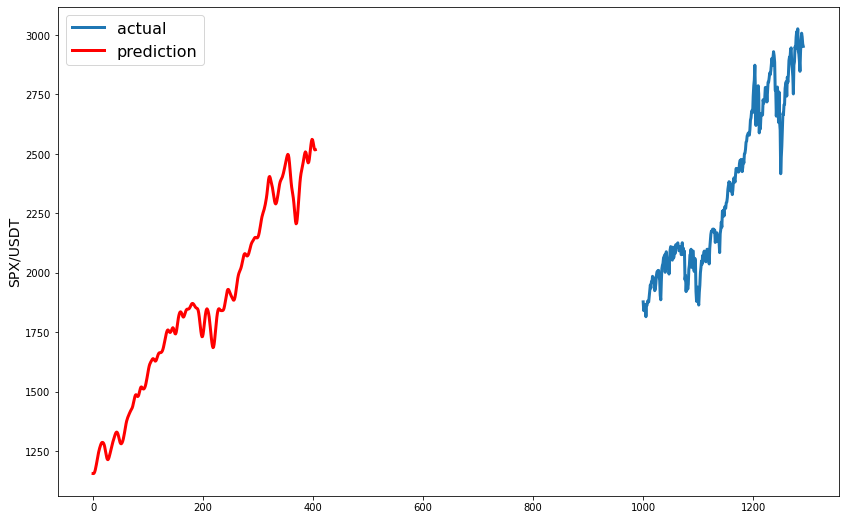

In [82]:
line_plot(test_SPX, pred, 'actual', 'prediction', lw=3)


---